# Keep Random Beacon Simulation - Study 1
## Analyzing the effect of group size and node failures on dominator rates

This study seeks to understand the impact of group size and node failure rates on number of nodes that can become dominators of a group. The study uses the Keep Random Beacon Simulation (see simulation master).

To perform the study we run the simulation 1000 times for a given tuple of group size and failure rate. We leave the node death rate as constant, so all nodes are assumed to reconnect after failure.


## Initializing Variables

Variables are initialized similar to the master sim except for:
* group_size -> group_size_array: This is changed to an array of group sizes 
* node_failure_percent -> node_failure_percent_array: this is changed to an array of failure %'s 

In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt

# Group & Signature Parameters
group_size_array = [10, 20, 30, 40, 50, 60, 70]# number of virtual stakers in a group - nodes to stakers is a 1-many relationship
nodes = 100 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 3 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
max_malicious_threshold = 50 # % of malicious node ownership needed to sign
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 10 # number of steps after which a group expires
Misbehaving_DKG_nodes = 10 # percent of nodes misbehaving during dkg
dkg_block_delay = 3 # blocks needed to run DKG

#Node parameters
node_failure_percent_array = [10, 20, 30, 40, 50, 60, 70] # % of times nodes fail and have to reconnect
node_death_percent = 2 # % of time nodes fail and do not reconnect
node_connection_delay = 3 # max delay for a node to connect or reconnect after failure
node_mainloop_connection_delay = 3 # max delay for a node to fork or refork mainloop after failure

#Model Parameters
log_filename = 'group_failure_dominator_study.log'
runs = 10
steps = 100

## Generating ticket distribution for each node

The ticket distribution determines how many tickets a node will generate during the group registration process. The charts below help visualize the shape of the distribution. The x-axis is the Node ID, and the y-axis shows the number of tickets for a node. Since the ticket selection process is uniform random we expect that the number of virtual stakers owned by a node in a group will be proportional to the number of tickets they generate. This has been validated by a previous analysis.

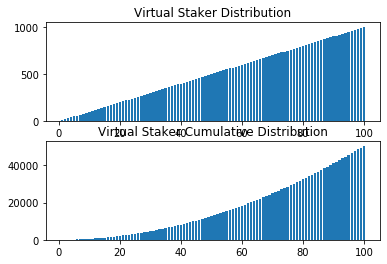

In [2]:
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=model.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")
plt.savefig("eth_distribution.png")

## Run the model & measure the parameters of interest

In [3]:
#initialize parameter measures
dominator_distributions_2 = []
total_dominator_percents_2 = []
dominator_medians_2 = []
total_sig_failure_percents_2 = []
for node_failure_percent in node_failure_percent_array:
    dominator_distributions_1 = []
    total_dominator_percents_1 = []
    dominator_medians_1 = []
    total_sig_failure_percents_1 = []
    for group_size in group_size_array:
        dominator_distributions = []
        total_dominator_percents = []
        total_sig_failure_percents = []
        for run_number in range(runs):
            # initialize the model
            beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                          active_group_threshold, 
                                          group_size, 
                                          max_malicious_threshold, 
                                          group_expiry, 
                                          node_failure_percent, 
                                          node_death_percent, 
                                          signature_delay,
                                          min_nodes,
                                          node_connection_delay,
                                          node_mainloop_connection_delay,
                                          log_filename,
                                          run_number,Misbehaving_DKG_nodes,dkg_block_delay)
            for i in range (steps):
                # step the model
                beacon_model.step()
                # Calculate the dominator distribution and totals for each run
                dominator_distr = np.zeros(nodes)
                signature_count = 0
                failed_signatures =0
                for signature in beacon_model.schedule.agents:
                    if signature.type == "signature":
                        failed_signatures+=signature.signature_failure 
                        signature_count+=1
                        if signature.dominator_id>=0:
                            dominator_distr[signature.dominator_id] += 1 #count only if a dominator id has been set
            dominator_distributions.append(dominator_distr)
            total_sig_failure_percents.append(round(failed_signatures/signature_count*100,1))
            total_dominator_percents.append(round(sum(dominator_distr)/signature_count*100,1))
        dominator_distributions_1.append(dominator_distributions)
        total_sig_failure_percents_1.append(total_sig_failure_percents)
        total_dominator_percents_1.append(total_dominator_percents)
        dominator_medians_1.append(np.median(total_dominator_percents))
    dominator_distributions_2.append(dominator_distributions_1)
    total_sig_failure_percents_2.append(total_sig_failure_percents_1)
    total_dominator_percents_2.append(total_dominator_percents_1)
    dominator_medians_2.append(dominator_medians_1)


TypeError: __init__() missing 3 required positional arguments: 'min_stake_amount', 'operator_mode', and 'malicious_operator_percent'

In [ ]:
import pandas as pd
df = pd.DataFrame(dominator_medians_2, columns= group_size_array)
df.insert(0,'Failure %',node_failure_percent_array)
df.set_index('Failure %')
df


In [ ]:
total_sig_failure_percents_2

Steady state percentage of dominated signatures within for a range of groups and failure rates 

Steady state signature failure (offline nodes above a threshold) same as above

change - "compromised groups can still be picked for signature"


Two most important constants:
Group size
Min Stake
max node count = active tokens/min stake (requires second layer of ownership as below)
min node count = number of grants aka number of stakers ( be fixed on day 0)

Another layer of ownership to allow 1 owner to own multiple nodes - To think about for later
